Created on Tue Feb 10 15:12:53 2014
@author: Alexander Pitchford
@email1: agp1@aber.ac.uk
@email2: alex.pitchford@gmail.com
@organization: Aberystwyth University
@supervisor: Daniel Burgarth

Example to demonstrate using the control library to determine control
pulses using the ctrlpulseoptim.optimize_pulse function.
The (default) L-BFGS-B algorithm is used to optimise the pulse to
minimise the fidelity error, which in this case is given by the
'Trace difference' norm.

This in an open quantum system example, with a single qubit subject to
an amplitude damping channel. The target evolution is the Hadamard gate.
For a d dimensional quantum system in general we represent the Lindbladian
as a d^2 x d^2 dimensional matrix by vectorizing the denisty operator (row vectorization).
Here done for the Lindbladian that describes the amplitude damping channel
and the coherent drift- and control generators.
The user can experiment with the strength of the amplitude damping by
changing the gamma variable value

The user can experiment with the timeslicing, by means of changing the
number of timeslots and/or total time for the evolution.
Different initial (starting) pulse types can be tried.
The initial and final pulses are displayed in a plot

In [74]:
import sys
import numpy as np
import numpy.matlib as mat
from numpy.matlib import kron
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import datetime

#QuTiP
from qutip import (Qobj, identity, sigmax, sigmay, sigmaz, sigmam, sigmap,
                   basis, ket2dm, tensor, Bloch, destroy, coherent)
from qutip.metrics import fidelity
from qutip.superoperator import (spre, sprepost, liouvillian,
                                vector_to_operator, operator_to_vector)
from qutip.visualization import (plot_wigner)
from qutip.qip import hadamard_transform
import qutip.logging_utils as logging
logger = logging.get_logger()

#QuTiP control modules
import qutip.control.pulseoptim as cpo

example_name = 'Lindblad_compare'
log_level = logging.WARN

REPORT_STATS = False

In [75]:
# ****************************************************************
N = 8
# Define the physics of the problem
Si = identity(2)
Ri = identity(N)

Sx = tensor(sigmax(),Ri)
Sy = tensor(sigmay(),Ri)
Sz = tensor(sigmaz(),Ri)

b = tensor(sigmap(), Ri)
a = destroy(N)
n = tensor(Si, a.dag()*a)

Sm = tensor(sigmam() , Ri)
#Hadamard gate
#had_gate = hadamard_transform(1)

# Hamiltonian
Del = 0.1    # Tunnelling term
wq = 1.0   # Energy of the 2-level system.
wq2 = 4.0   # Energy of the resonator.
H0 = 0.5*wq*Sz + 0.5*wq2*n

#Amplitude damping#
#Damping rate:
#gamma = 0.03
gamma = 2*np.pi*2e-6
gamma = 0

# qutip column vectorisation
L0 = liouvillian(H0, [np.sqrt(gamma)*Sm])

#sigma X control
LC_x = liouvillian(Sx)
#LC_x2 = liouvillian(Sx2)
#sigma Y control
LC_y = liouvillian(Sy)
#sigma Z control
LC_z = liouvillian(Sz)
#LC_z2 = liouvillian(Sz2)

psi0 = tensor(basis(2, 0), basis(N, 0))
rho0 = ket2dm(psi0)
print("rho0:\n{}\n".format(rho0))
rho0_vec = operator_to_vector(rho0)
#rho0_vec = rho0
print("rho0_vec:\n{}\n".format(rho0_vec))

psi_targ = tensor((1j*basis(2, 0)+basis(2, 1)).unit() , basis(N, 0))
rho_targ = ket2dm(psi_targ)
print("rho_targ:\n{}\n".format(rho_targ))
rho_targ_vec = operator_to_vector(rho_targ)
#rho_targ_vec = rho_targ
print("rho_targ_vec:\n{}\n".format(rho_targ_vec))

#print("L0:\n{}\n".format(L0))
#print("LC_x:\n{}\n".format(LC_x))
#print("LC_y:\n{}\n".format(LC_y))
#print("LC_z:\n{}\n".format(LC_z))

print("Fidelity rho0, rho_targ: {}".format(fidelity(rho0, rho_targ)))

rho_diff = (rho0 - rho_targ)
fid_err = 0.5*(rho_diff.dag()*rho_diff).tr()
print("fid_err: {}, fid: {}".format(fid_err, np.sqrt(1 - fid_err)))

#rho0_evo_map = vector_to_operator(E_targ*rho0_vec)
#print("Fidelity rho_targ, rho0_evo_map: {}".format(fidelity(rho_targ, rho0_evo_map)))


#Drift
drift = L0

#Controls
ctrls = [LC_x, LC_z]
#ctrls = [LC_y]
#ctrls = [LC_x]
#ctrls = [liouvillian(b.dag()), liouvillian(b), liouvillian(b2.dag()), liouvillian(b2)]

# Number of ctrls
n_ctrls = len(ctrls)

rho0:
Quantum object: dims = [[2, 8], [2, 8]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

rho0_vec:
Quantum object: dims = [[[2, 8], [2, 8]], [1]], shape = (256, 1), ty

In [76]:
# ***** Define time evolution parameters *****
# Time slot length
l_ts = 1

# Time allowed for the evolution (nanosec)
evo_time = 100

# Number of time slots
n_ts = int(evo_time//l_ts + 1)

# ***** Define the termination conditions *****
# Fidelity error target
fid_err_targ = 1e-6

# Maximum iterations for the optisation algorithm
max_iter = 500

# Maximum (elapsed) time allowed in seconds
max_wall_time = 60

# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

# Initial pulse type
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND'

# *************************************************************

# File extension for output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)
f_ext = None


***********************************
Starting pulse state-state optimisation


/home/wello/miniconda3/envs/qutip-env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The 'accuracy_factor' parameter is deprecated. Use 'accuracy_factor' in method_params instead


***********************************

Optimising complete.
Final evolution
Quantum object: dims = [[[2, 8], [2, 8]], [1]], shape = (256, 1), type = operator-ket
Qobj data =
[[ 0.51532259-6.50072657e-16j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [-0.01130273-4.99637335e-01j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.000000

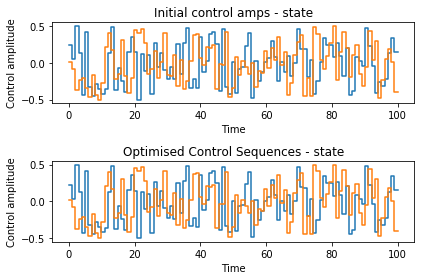

In [77]:
# Run the optimisation

print("\n***********************************")
print("Starting pulse state-state optimisation")

# Note that this call will take the defaults
#    dyn_type='GEN_MAT'
# This means that matrices that describe the dynamics are assumed to be
# general, i.e. the propagator can be calculated using:
# expm(combined_dynamics*dt)
#    prop_type='FRECHET'
# and the propagators and their gradients will be calculated using the
# Frechet method, i.e. an exact gradent
#    fid_type='TRACEDIFF'
# and that the fidelity error, i.e. distance from the target, is give
# by the trace of the difference between the target and evolved operators

result_s = cpo.optimize_pulse(drift, ctrls, rho0_vec, rho_targ_vec,
                n_ts, evo_time,
                fid_err_targ=fid_err_targ, min_grad=min_grad,
                max_iter=max_iter, max_wall_time=max_wall_time,
                amp_lbound=-0.5, amp_ubound=0.5,
#                dyn_params={'oper_dtype':Qobj},
#                prop_type='AUG_MAT',
#                fid_type='UNIT',
                fid_params={'phase_option':'PSU'},
                accuracy_factor=1,
                out_file_ext=f_ext, init_pulse_type=p_type,
                log_level=log_level, gen_stats=True)

print("***********************************")
print("\nOptimising complete.")

if REPORT_STATS:
    print("Stats follow:")
    result_s.stats.report()

print("Final evolution\n{}\n".format(result_s.evo_full_final))
print("********* Summary - state optim *******")
print("Initial fidelity error {}".format(result_s.initial_fid_err))
print("Final fidelity error {}".format(result_s.fid_err))
print("unit gate fidelity {}".format(np.sqrt(1- result_s.fid_err)))
print("Terminated due to {}".format(result_s.termination_reason))
print("Number of iterations {}".format(result_s.num_iter))
#print("wall time: ", result.wall_time
print("Completed in {} HH:MM:SS.US".format(
                datetime.timedelta(seconds=result_s.wall_time)))

if result_s.evo_full_final.isoperket:
    rhoTs = vector_to_operator(result_s.evo_full_final)
else:
    rhoTs = result_s.evo_full_final

# print("Final gradient normal {}".format(result.grad_norm_final)
print("***********************************")

print("Fidelity state evolved by state: {}".format(fidelity(rhoTs, rho_targ)))

def plot_pulses(result, res_lbl):
    # Plot the initial and final amplitudes
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(2, 1, 1)
    ax1.set_title("Initial control amps - {}".format(res_lbl))
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Control amplitude")
    for j in range(n_ctrls):
        ax1.step(result.time,
                 np.hstack((result.initial_amps[:, j],
                            result.initial_amps[-1, j])),
                 where='post')

    ax2 = fig1.add_subplot(2, 1, 2)
    ax2.set_title("Optimised Control Sequences - {}".format(res_lbl))
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Control amplitude")
    for j in range(n_ctrls):
        ax2.step(result.time,
                 np.hstack((result.final_amps[:, j],
                            result.final_amps[-1, j])),
                 where='post')
    fig1.tight_layout()

plot_pulses(result_s, 'state')

plt.show()


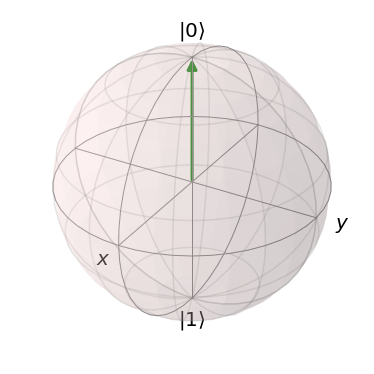

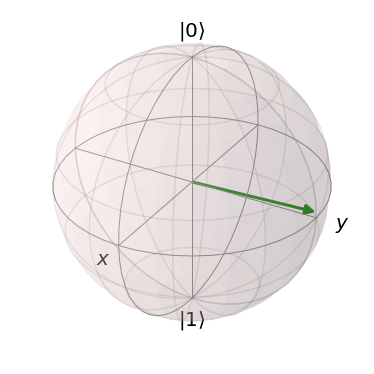

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa1b80f3d68>)

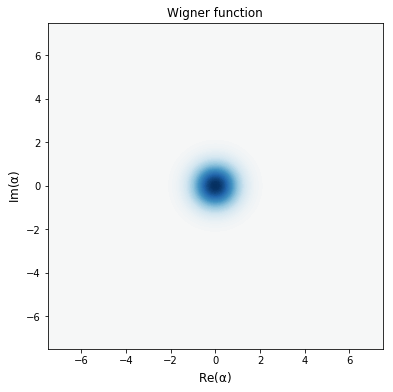

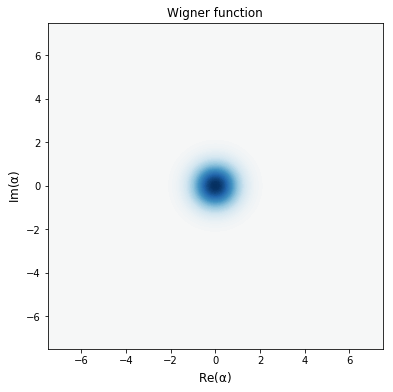

In [78]:
i_s = rho0
#i_s = result_s.evo_full_initial
bl = Bloch()
bl.add_states(i_s.ptrace(0))
#bl.add_states(i_s.ptrace(1))
bl.show()

f_s = result_s.evo_full_final
bl2 = Bloch()
bl2.add_states(f_s.ptrace(0))
#bl2.add_states(f_s.ptrace(1))
bl2.show()

plot_wigner(i_s.ptrace(1))
plot_wigner(f_s.ptrace(1))